# Models comparison

**Objective:** compare logistic regression model, random forest model and the PHASES score.

## Library importation

In [1]:
library(ROCR)
library(randomForest)
library(pls)
library(ggplot2)
library(dplyr)
library(tidyverse)

Loading required package: gplots


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'pls'


The following object is masked from 'package:stats':

    loadings



Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin



Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

v tibble  2.1.3     v purrr   0.3.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::combine()  masks randomForest::co

## Data loading

In [2]:
ican <- read.csv("simulated_ican_clinical_data.csv", sep = "#", encoding = "utf8")
dim(ican)
set.seed(123)

[1] 2505   29

In [3]:
adjusted_IA_size_class <- c()
for (i in 1:dim(ican)[1]) {
    if (ican$adjusted_IA_size[i] < 3) {
        adjusted_IA_size_class[i] <- "<3"
    } else if (ican$adjusted_IA_size[i] >= 3) {
        adjusted_IA_size_class[i] <- ">=3"
    } else {
        adjusted_IA_size_class[i] <- "Other"
    }
}
ican["adjusted_IA_size"] <- as.factor(adjusted_IA_size_class)

In [4]:
age_class <- c()
for (i in 1:dim(ican)[1]) {
    if (ican$age[i] < 50) {
        age_class[i] <- "<50"
    } else if (ican$age[i] < 60) {
        age_class[i] <- "50-59"
    } else if (ican$age[i] < 70) {
        age_class[i] <- "60-69"
    } else if (ican$age[i] >= 70) {
        age_class[i] <- ">=70"
    } else {
        age_class[i] <- "Other"
    }
}
ican["age"] <- as.factor(age_class)

In [5]:
ican_LR <- ican[,-dim(ican)[2]]
ican_RF <- ican[,-dim(ican)[2]]

In [6]:
bmi_class <- c()
for (i in 1:dim(ican)[1]) {
    if (ican$bmi[i] < 20) {
        bmi_class[i] <- "<20"
    } else if (ican$bmi[i] < 25) {
        bmi_class[i] <- "20-25"
    } else if (ican$bmi[i] < 30) {
        bmi_class[i] <- "25-30"
    } else if (ican$bmi[i] >= 30) {
        bmi_class[i] <- ">=30"
    } else {
        bmi_class[i] <- "Other"
    }
}
ican_RF["bmi"] <- as.factor(bmi_class)

## Train / Test

In [7]:
cut <- cvsegments(N = nrow(ican), k = 10)

## PHASES score

In [8]:
nmax = max(ican$PHASES_score)
tpr_phases = 1:(nmax+2)
fpr_phases = 1:(nmax+2)
tpr_phases[nmax+2] = 0
fpr_phases[nmax+2] = 0
for(i in 1:nmax){
    cm = table(ican$rupture, ican$PHASES_score >= i)
    tpr_phases[i+1] = cm[2,2]/length(which(ican$rupture == "Yes"))
    fpr_phases[i+1] = cm[1,2]/length(which(ican$rupture == "No"))
}

In [9]:
div_score <- ican$PHASES_score / 16

In [10]:
prediction_obj <- prediction(div_score, ican$rupture)
perf <- performance(prediction_obj, measure = "auc")
print(paste("AUC PHASES score =", round(perf@y.values[[1]], 2)))

[1] "AUC PHASES score = 0.5"


## Multivariables Logistic Regression

In [11]:
val_auc_LR <- 1:10
x_values_roc_LR <- matrix(nrow = 10, ncol = 252)
y_values_roc_LR <- matrix(nrow = 10, ncol = 252)
sensitivity_LR <- 1:10
specificity_LR <- 1:10
accuracy_LR <- 1:10
val_youden_LR <- 1:10
TP_val_LR <- 1:10
TN_val_LR <- 1:10
FP_val_LR <- 1:10
FN_val_LR <- 1:10
for (i in 1:10) {
    train_LR <- ican_LR[-cut[[i]],]
    test_LR <- ican_LR[cut[[i]],]
    fit_LR <- glm(rupture ~ sex + age + adjusted_IA_size + IA_location + hta + packs_year + ischemic_stroke_history + 
                            headaches + ischemic_heart_disease_history + multiple_IA + allergy + alcohol, 
                  data = train_LR, family = "binomial") 
    
    pred_valid_LR <- predict(fit_LR, newdata = test_LR, type = "response")
    pr_valid_LR <- prediction(pred_valid_LR, test_LR$rupture) 
    roc_valid_LR <- performance(pr_valid_LR, measure = "tpr", x.measure = "fpr")
    test_x_LR <- as.vector(roc_valid_LR@x.values[[1]])
    test_y_LR <- as.vector(roc_valid_LR@y.values[[1]])
    while (length(test_x_LR) < 252) {
        test_x_LR[length(test_x_LR) + 1] <- 1
        test_y_LR[length(test_y_LR) + 1] <- 1
    }
    x_values_roc_LR[i, ] <- test_x_LR
    y_values_roc_LR[i, ] <- test_y_LR
    
    ind_youden <- pr_valid_LR@tp[[1]]/(pr_valid_LR@tp[[1]] + pr_valid_LR@fn[[1]]) + pr_valid_LR@tn[[1]]/(pr_valid_LR@tn[[1]] + pr_valid_LR@fp[[1]]) - 1
    val_youden_LR[i] <- pr_valid_LR@cutoffs[[1]][which(ind_youden == max(ind_youden))]
    
    cm <- table(test_LR$rupture, pred_valid_LR > val_youden_LR[i])
    
    TP <- cm["Yes","TRUE"]
    TN <- cm["No","FALSE"]
    FP <- cm["No","TRUE"]
    FN <- cm["Yes","FALSE"]
    
    TP_val_LR[i] <- TP
    TN_val_LR[i] <- TN
    FP_val_LR[i] <- FP
    FN_val_LR[i] <- FN
    
    sensitivity_LR[i] <- TP / (TP + FN)
    specificity_LR[i] <- TN / (TN + FP)
    accuracy_LR[i] <- (TP + TN) / (TP + TN + FP + FN)
    
    prediction.obj_LR <- prediction(pred_valid_LR, test_LR$rupture)
    perf_LR <- performance(prediction.obj_LR, measure = "auc")
    val_auc_LR[i] <- round(perf_LR@y.values[[1]], 2)
}

In [12]:
print("Youden index cutoff")
print(paste("Mean Cutoff =", round(mean(val_youden_LR), 3)))
print(paste("Sensitivity =", round(mean(sensitivity_LR), 3)))
print(paste("Specificity =", round(mean(specificity_LR), 3)))
print(paste0("Accuracy = ", round(mean(accuracy_LR), 3), " [", 
             round(round(mean(accuracy_LR), 3)- 1.96*round(sd(accuracy_LR), 3)/sqrt(10),3),
             ";", round(round(mean(accuracy_LR), 3)+1.96*round(sd(accuracy_LR), 3)/sqrt(10),3), "]"))
print(paste0("AUC = ", round(mean(val_auc_LR), 3), " [", 
             round(round(mean(val_auc_LR), 3)- 1.96*round(sd(val_auc_LR), 3)/sqrt(10),3),
             ";", round(round(mean(val_auc_LR), 3)+1.96*round(sd(val_auc_LR), 3)/sqrt(10),3), "]"))

[1] "Youden index cutoff"
[1] "Mean Cutoff = 0.395"
[1] "Sensitivity = 0.585"
[1] "Specificity = 0.493"
[1] "Accuracy = 0.524 [0.476;0.572]"
[1] "AUC = 0.507 [0.478;0.536]"


In [13]:
print(paste("TP =", mean(TP_val_LR)))
print(paste("TN =", mean(TN_val_LR)))
print(paste("FP =", mean(FP_val_LR)))
print(paste("FN =", mean(FN_val_LR)))

[1] "TP = 57"
[1] "TN = 74.2"
[1] "FP = 77.7"
[1] "FN = 41.6"


## Random Forest

In [14]:
val_auc_RF <- 1:10
x_values_roc_RF <- matrix(nrow = 10, ncol = 252)
y_values_roc_RF <- matrix(nrow = 10, ncol = 252)
sensitivity_RF <- 1:10
specificity_RF <- 1:10
accuracy_RF <- 1:10
val_youden_RF <- 1:10
TP_val_RF <- 1:10
TN_val_RF <- 1:10
FP_val_RF <- 1:10
FN_val_RF <- 1:10
for (i in 1:10) {
    train_RF <- ican_RF[-cut[[i]],]
    test_RF <- ican_RF[cut[[i]],]

    fit_RF <- randomForest(rupture ~ ., data = train_RF, ntree = 600, mtry = 6, importance = TRUE, 
                           nodesize = 1, maxnodes = 130)
    pred_valid_RF <- as.vector(predict(fit_RF, newdata = test_RF, type = "prob")[,2])
    pr_valid_RF <- prediction(pred_valid_RF, test_RF$rupture) 
    roc_valid_RF <- performance(pr_valid_RF, measure = "tpr", x.measure = "fpr")
    test_x_RF <- as.vector(roc_valid_RF@x.values[[1]])
    test_y_RF <- as.vector(roc_valid_RF@y.values[[1]])
    while (length(test_x_RF) < 252) {
        test_x_RF[length(test_x_RF) + 1] <- 1
        test_y_RF[length(test_y_RF) + 1] <- 1
    }
    x_values_roc_RF[i, ] <- test_x_RF
    y_values_roc_RF[i, ] <- test_y_RF
    
    ind_youden <- pr_valid_RF@tp[[1]]/(pr_valid_RF@tp[[1]] + pr_valid_RF@fn[[1]]) + pr_valid_RF@tn[[1]]/(pr_valid_RF@tn[[1]] + pr_valid_RF@fp[[1]]) - 1
    val_youden_RF[i] <- pr_valid_RF@cutoffs[[1]][which(ind_youden == max(ind_youden))]
    
    cm <- table(test_RF$rupture, pred_valid_RF > val_youden_RF[i])

    TP <- cm["Yes","TRUE"]
    TN <- cm["No","FALSE"]
    FP <- cm["No","TRUE"]
    FN <- cm["Yes","FALSE"]
    
    TP_val_RF[i] <- TP
    TN_val_RF[i] <- TN
    FP_val_RF[i] <- FP
    FN_val_RF[i] <- FN
    
    sensitivity_RF[i] <- TP / (TP + FN)
    specificity_RF[i] <- TN / (TN + FP)
    accuracy_RF[i] <- (TP + TN) / (TP + TN + FP + FN)
    
    prediction.obj_RF <- prediction(pred_valid_RF, test_RF$rupture)
    perf_RF <- performance(prediction.obj_RF, measure = "auc")
    val_auc_RF[i] <- round(perf_RF@y.values[[1]], 2)
}

In [15]:
print("Youden index cutoff")
print(paste("Mean Cutoff =", round(mean(val_youden_RF), 3)))
print(paste("Sensitivity =", round(mean(sensitivity_RF), 3)))
print(paste("Specificity =", round(mean(specificity_RF), 3)))
print(paste0("Accuracy = ", round(mean(accuracy_RF), 3), " [", 
             round(round(mean(accuracy_RF), 3)- 1.96*round(sd(accuracy_RF), 3)/sqrt(10),3),
             ";", round(round(mean(accuracy_RF), 3)+1.96*round(sd(accuracy_RF), 3)/sqrt(10),3), "]"))
print(paste0("AUC = ", round(mean(val_auc_RF), 3), " [", 
             round(round(mean(val_auc_RF), 3)- 1.96*round(sd(val_auc_RF), 3)/sqrt(10),3),
             ";", round(round(mean(val_auc_RF), 3)+1.96*round(sd(val_auc_RF), 3)/sqrt(10),3), "]"))

[1] "Youden index cutoff"
[1] "Mean Cutoff = 0.182"
[1] "Sensitivity = 0.61"
[1] "Specificity = 0.438"
[1] "Accuracy = 0.499 [0.458;0.54]"
[1] "AUC = 0.49 [0.47;0.51]"


In [16]:
print(paste("TP =", mean(TP_val_RF)))
print(paste("TN =", mean(TN_val_RF)))
print(paste("FP =", mean(FP_val_RF)))
print(paste("FN =", mean(FN_val_RF)))

[1] "TP = 59.3"
[1] "TN = 65.6"
[1] "FP = 86.3"
[1] "FN = 39.3"


## Roc curves comparison

In [17]:
sd_x_LR <- apply(x_values_roc_LR, 2, sd)
sd_y_LR <- apply(y_values_roc_LR, 2, sd)

sd_x_RF <- apply(x_values_roc_RF, 2, sd)
sd_y_RF <- apply(y_values_roc_RF, 2, sd)

In [18]:
x_test_LR = c(colMeans(x_values_roc_LR) - 1.96*sd_x_LR/sqrt(10), 
              colMeans(x_values_roc_LR) + 1.96*sd_x_LR/sqrt(10))
y_test_LR = c(colMeans(y_values_roc_LR) + 1.96*sd_y_LR/sqrt(10), 
              colMeans(y_values_roc_LR) - 1.96*sd_y_LR/sqrt(10))

x_test_RF = c(colMeans(x_values_roc_RF) - 1.96*sd_x_RF/sqrt(10), 
              colMeans(x_values_roc_RF) + 1.96*sd_x_RF/sqrt(10))
y_test_RF = c(colMeans(y_values_roc_RF) + 1.96*sd_y_RF/sqrt(10), 
              colMeans(y_values_roc_RF) - 1.96*sd_y_RF/sqrt(10))

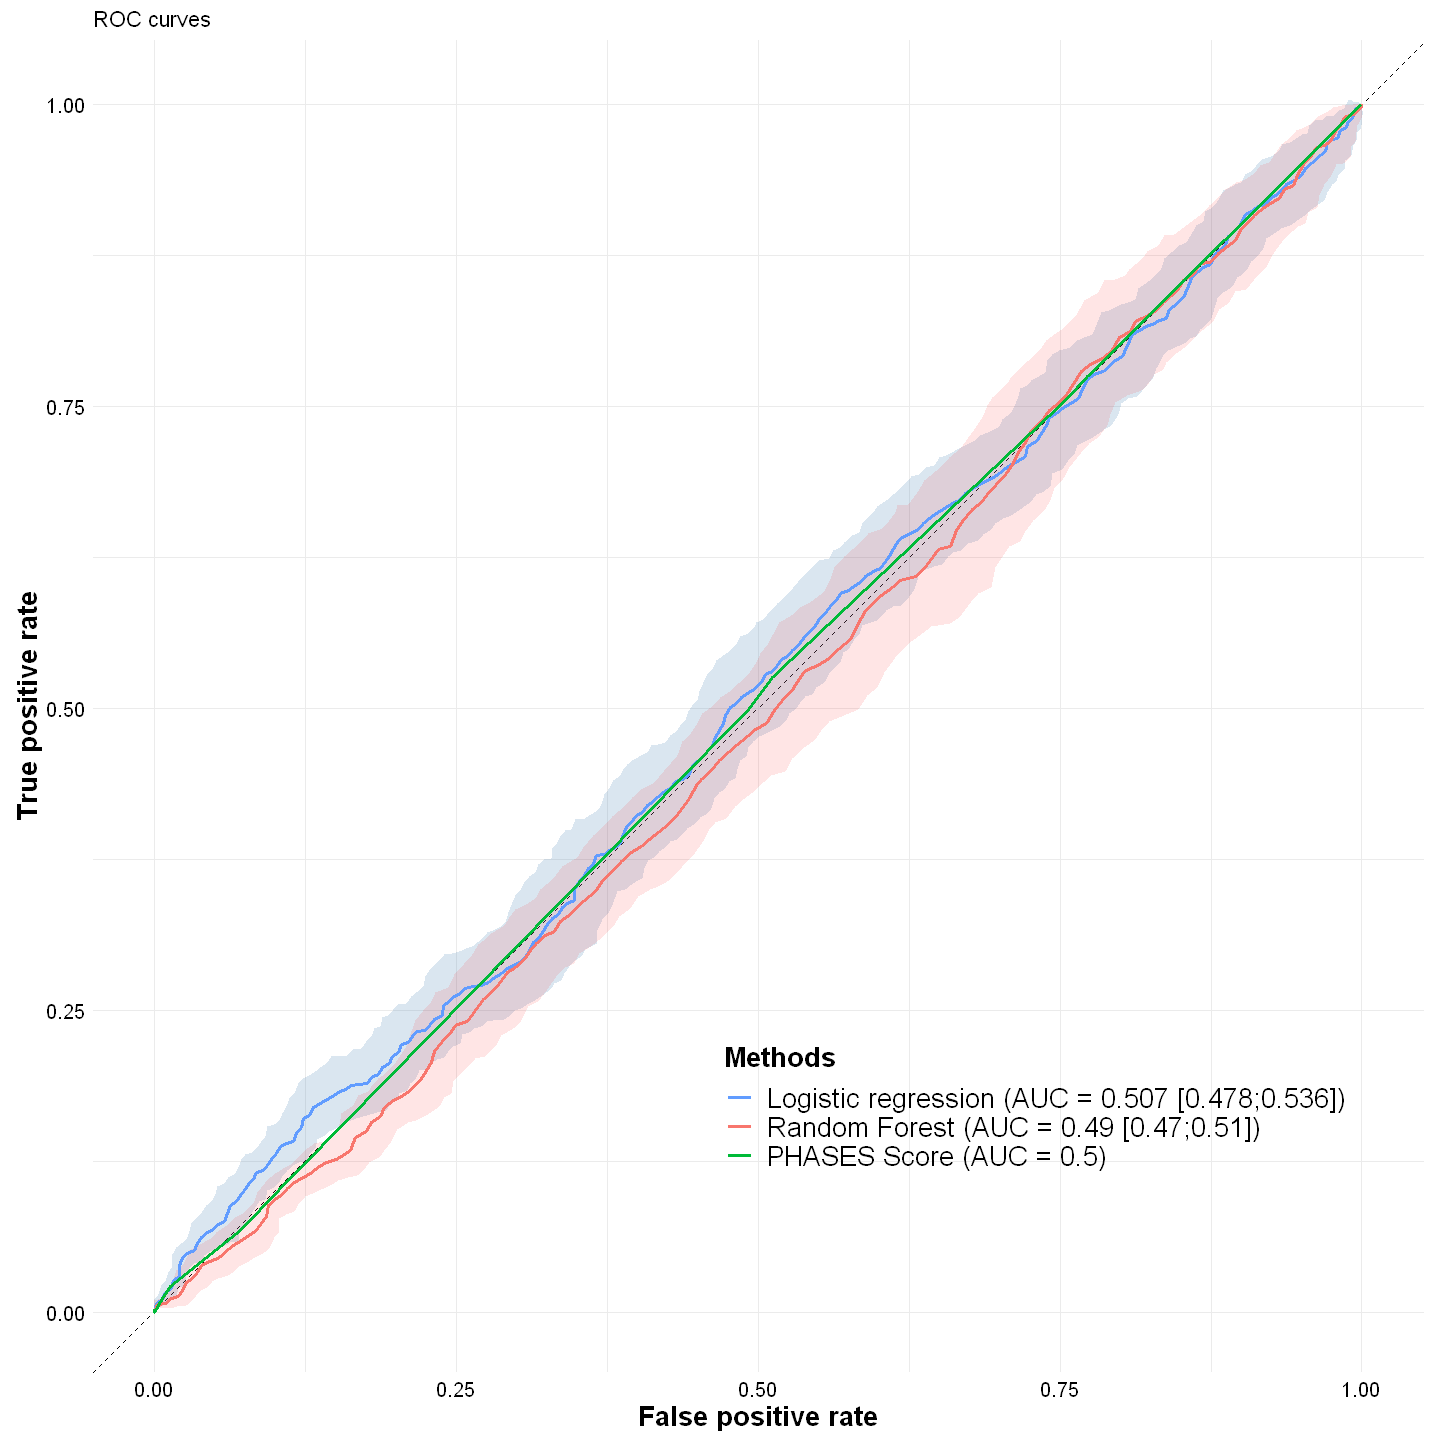

In [19]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggplot() + labs(x = "False positive rate", y = "True positive rate") + 
ggtitle("ROC curves") +
geom_abline(intercept = 0, slope = 1, color = "black", linetype = "dashed") +
geom_polygon(aes(x = x_test_LR, y = y_test_LR), fill = "steelblue", alpha= 0.2) +
geom_polygon(aes(x = x_test_RF, y = y_test_RF), fill = "red", alpha= 0.1) +
geom_line(aes(x = colMeans(x_values_roc_LR), y = colMeans(y_values_roc_LR), colour = "Y"), size = 1) +
geom_line(aes(x = colMeans(x_values_roc_RF), y = colMeans(y_values_roc_RF), colour = "#CC0000"), size = 1) +
geom_line(aes(x = fpr_phases, y = tpr_phases, colour = "green"), size = 1) +
theme_minimal() + 
coord_equal() + 
theme(axis.title.x = element_text(color="black", size=16, face="bold"),
      axis.title.y = element_text(color="black", size=16, face="bold"),
      axis.text.x = element_text(color="black", size=12),
      axis.text.y = element_text(color="black", size=12)) + 
scale_colour_discrete(name = "Methods", breaks = c("Y", "#CC0000", "green"), 
                      labels=c(paste0("Logistic regression (AUC = ", round(mean(val_auc_LR), 3), " [", 
                                      round(round(mean(val_auc_LR), 3)- 1.96*round(sd(val_auc_LR), 3)/sqrt(10),3),
                                      ";", round(round(mean(val_auc_LR), 3)+1.96*round(sd(val_auc_LR), 3)/sqrt(10),3), "])"),
                               paste0("Random Forest (AUC = ", round(mean(val_auc_RF), 3), " [", 
                                      round(round(mean(val_auc_RF), 3)- 1.96*round(sd(val_auc_RF), 3)/sqrt(10),3),
                                      ";", round(round(mean(val_auc_RF), 3)+1.96*round(sd(val_auc_RF), 3)/sqrt(10),3), "])"),
                               paste0("PHASES Score (AUC = ", round(perf@y.values[[1]], 2), ")"))) +
theme(legend.position = c(0.7, 0.2)) + 
theme(legend.title = element_text(colour="black", size=16, face="bold")) + 
theme(legend.text = element_text(colour="black", size=16))


### AUC methods comparison

In [20]:
info_min <- c(min(val_auc_LR), min(val_auc_RF))
info_mean <- c(mean(val_auc_LR), mean(val_auc_RF))
info_median <- c(median(val_auc_LR), median(val_auc_RF))
info_max <- c(max(val_auc_LR), max(val_auc_RF))

In [21]:
df_info <- data.frame(info_min, info_mean, info_median, info_max, row.names = c("Logistic Regression", "Random Forest"))
colnames(df_info) <- c("Minimum", "Mean", "Median", 'Maximum')
round(df_info,3)

,Minimum,Mean,Median,Maximum
,<dbl>,<dbl>,<dbl>,<dbl>
Logistic Regression,0.42,0.507,0.510,0.59
Random Forest,0.45,0.490,0.485,0.54
